El siguiente codigo se basa en desarrollar una red neuronal para el pronostico de energia solar a corto plazo mediante python, se utiliza datos diarios obtenidos de: 
https://github.com/ColasGael/Machine-Learning-for-Solar-Energy-Prediction

En especifico, datos de producción diaria de energía del parque solar Urbana-Champaign y cobertura nubosa.

In [36]:
#Importar librerias utilizadas y leyendo datos
import matplotlib as mp 
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

#el formato de archivo es en excel
archivo_xlsx = 'datos_red1.xlsx' 

#leer el archivo .xlsx en un DataFrame
data = pd.read_excel(archivo_xlsx)
print(data.head()) #mostrar el inicio del DataFrame

        Date  Cloud coverage  Visibility  Temperature  Dew point  \
0 2016-02-01            0.10        9.45         3.11       0.32   
1 2016-02-02            0.80        3.94         6.99       6.22   
2 2016-02-03            0.87        8.70         1.62       0.02   
3 2016-02-04            0.37       10.00        -2.47      -5.89   
4 2016-02-05            0.52        9.21        -2.00      -4.15   

   Relative humidity  Wind speed  Station pressure  Altimeter  Solar energy  \
0              79.46        4.70             29.23      30.02         20256   
1              93.60       13.29             28.91      29.70          1761   
2              85.00       16.73             29.03      29.82          2775   
3              74.52        9.46             29.46      30.26         28695   
4              82.03        5.92             29.55      30.35          9517   

   (Inverters)  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  


In [37]:
#calculamos correlacion entre la variable dependiente e independiente. Es importante que el valor de esta sea el maximo posible
#pues a mayor correlacion, la relación lineal entre ellas es mas fuerte. 

#recordando se utilizara la energia solar(dependiente) y la cobertura nubosa(independiente)
correlation = data['Solar energy'].corr(data['Cloud coverage']) 
print(f"Correlación de Pearson con 'Solar energy' con 'Cloud coverage': {correlation}")

Correlación de Pearson con 'Solar energy' con 'Cloud coverage': -0.6879608693319484


La mayor conrrelacion encontrada se da entre estas dos variables, al ser negativa implica que a mayor cobertura nubosa menor energia solar se produce. 

In [38]:
#seleccionar variables a utilizar en forma de vectores
fecha = data.iloc[:, 0]
solar_energy = data.iloc[:, 9]
cloud_coverage = data.iloc[:, 1]
#print(fecha)
#print(solar_energy)
print(cloud_coverage)

0      0.10
1      0.80
2      0.87
3      0.37
4      0.52
       ... 
632    0.23
633    0.01
634    0.89
635    0.99
636    0.58
Name: Cloud coverage, Length: 637, dtype: float64


Correlación de Pearson, con cobertura nubosa: -0.69


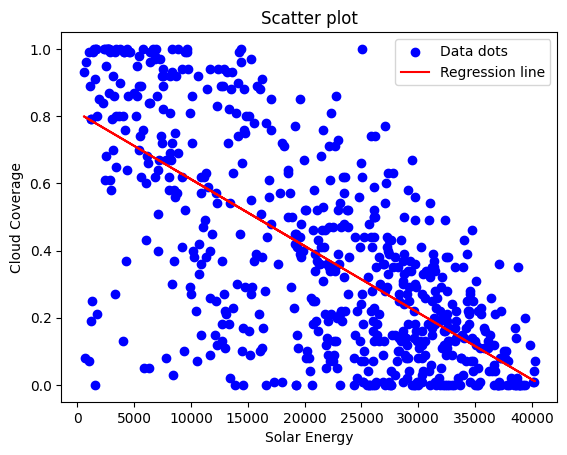

In [39]:
#Grafico de dispersion de los datos con linea de regresion
plt.scatter(solar_energy, cloud_coverage, label="Data dots", color="b")
slope, intercept = np.polyfit(solar_energy, cloud_coverage, 1)
regression_line = slope * solar_energy + intercept
print(f"Correlación de Pearson, con cobertura nubosa: {correlation:.2f}")
plt.plot(solar_energy, regression_line, color='r', label='Regression line')
# Etiquetas y título del gráfico
plt.xlabel("Solar Energy")
plt.ylabel("Cloud Coverage")
plt.title("Scatter plot")
plt.legend()
plt.show()

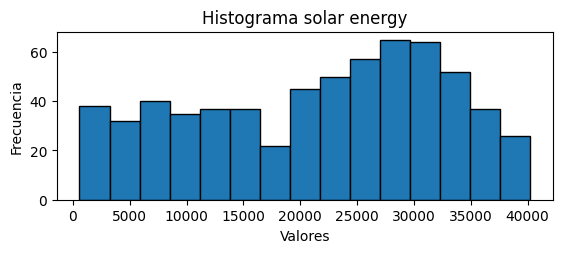

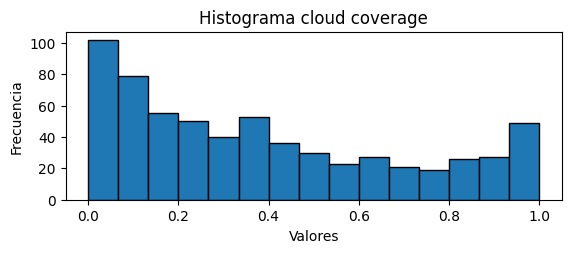

In [40]:
#histogramas de las variables para visualizar como se distribuyen los datos

plt.subplot(2, 1, 1) # 2 filas, 1 columna
plt.hist(solar_energy, bins=15, edgecolor='black')  # "bins" define el número de divisiones en el histograma
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma solar energy')
plt.show()

plt.subplot(2, 1, 2)
plt.hist(cloud_coverage, bins=15, edgecolor='black') 
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma cloud coverage')
plt.show()

En la cobertura nubosa la mayor frecuencia de datos es en 0, esto puede tener alguna consecuencia en el aprendizaje del modelo? Debido a que al ingresar los inputs al modelo estos se multiplican con los pesos y luego se suman, un valor de 0 podria nno aportaria informacion al proceso de aprendizaje (es lo mismo que ocurre con datos en horario de noche, no hay radiacion por lo que no aportan al aprendizaje)

Se invertira la escala de 'cloud_coverage', es decir, originalmente los datos van de [0,1] con menor cobertura nubosa a mayor. Ahora dejaremos los datos de esta forma [1,0] una menor cobertura nubosa corresponde a valores cercanos a 1 y viceversa. 

Correlación de Pearson, con cobertura nubosa [1,0]: 0.69


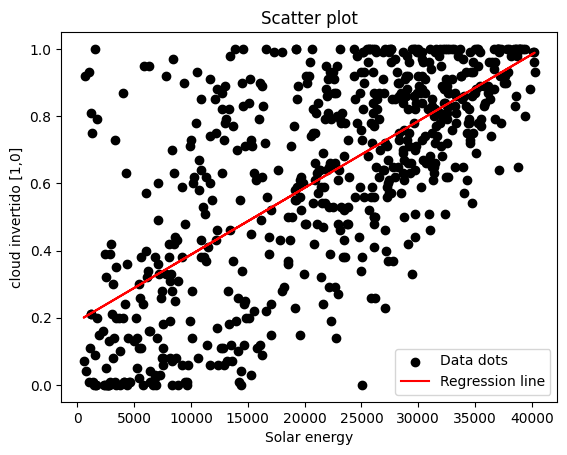

In [41]:
#escala de cloud_coverage invertida
 
#un valor de 1, significa que no hay cobertura nubosa
#un valor de 0, significa que hay cobertura nubosa
cloud_invertido = 1 - cloud_coverage 

correlation = data['Solar energy'].corr(cloud_invertido) 
print(f"Correlación de Pearson, con cobertura nubosa [1,0]: {correlation:.2f}")

plt.scatter(solar_energy, cloud_invertido, label="Data dots", color="black")
slope, intercept = np.polyfit(solar_energy, cloud_invertido, 1)
regression_line = slope * solar_energy + intercept
plt.plot(solar_energy, regression_line, color='r', label='Regression line')
# Etiquetas y título del gráfico
plt.xlabel("Solar energy")
plt.ylabel("cloud invertido [1,0]")
plt.title("Scatter plot")
plt.legend()
plt.show()

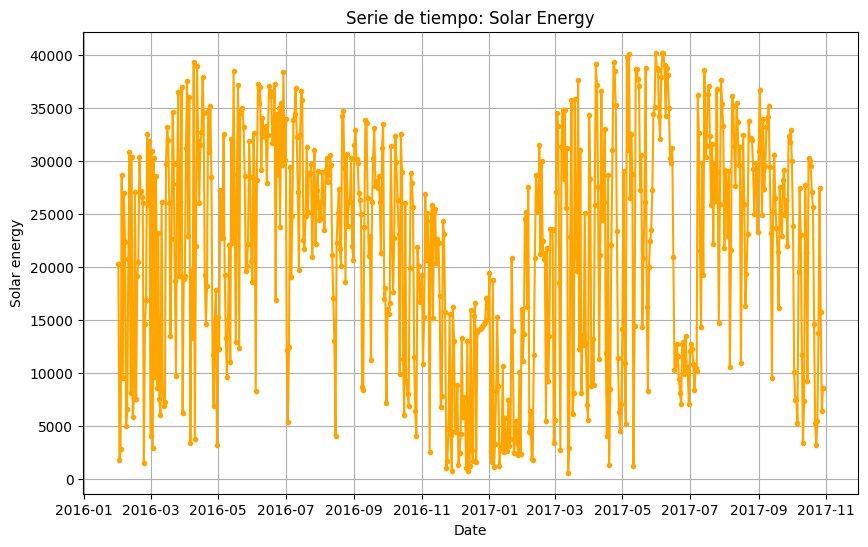

In [42]:
#Observando la serie de tiempo de 'Solar energy'

#5/30/2017 formato de fecha original
#pasamos el vector de fechas a otro formato, utilizando la funcion datetime
fechas = pd.to_datetime(fecha, format="%m/%d/%Y")

#dejamos todos los datos en un dataframe (o matriz)
df = pd.DataFrame({'Fecha': fechas, 'Valores': solar_energy, 'Cloud' : cloud_invertido})
#df = pd.DataFrame({'Fecha': fechas, 'Valores': solar_energy, 'Cloud' : cloud_coverage})
#df = df.sort_values(by='Fecha') para ordenar en caso de que no estuviese en orden cronologico

#Crear el gráfico de la serie de tiempo
#lamentablemente no se expresa la unidad de la energia solar en la base de datos, pero debiese estar en W/m^2
plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.plot(df['Fecha'], df['Valores'], marker='.', linestyle='-',color='orange')
plt.title('Serie de tiempo: Solar Energy')
plt.xlabel('Date')
plt.ylabel('Solar energy')
plt.grid(True)

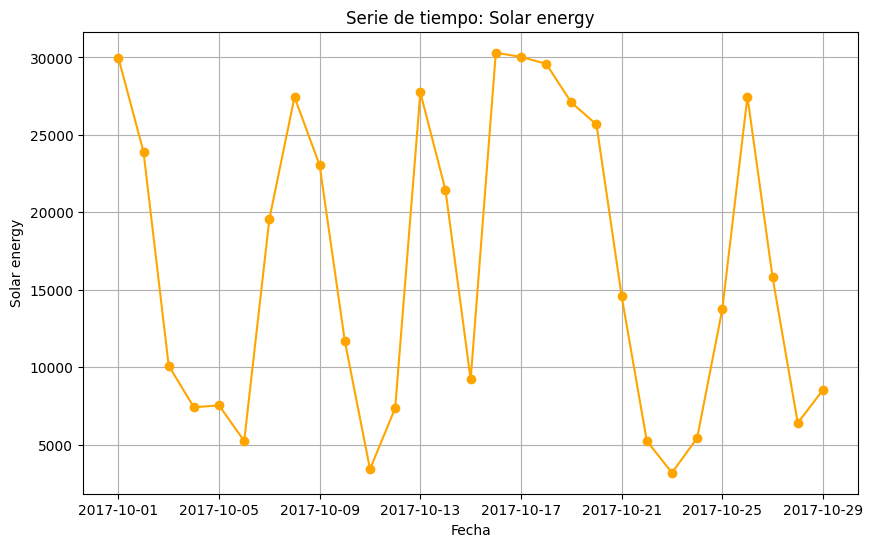

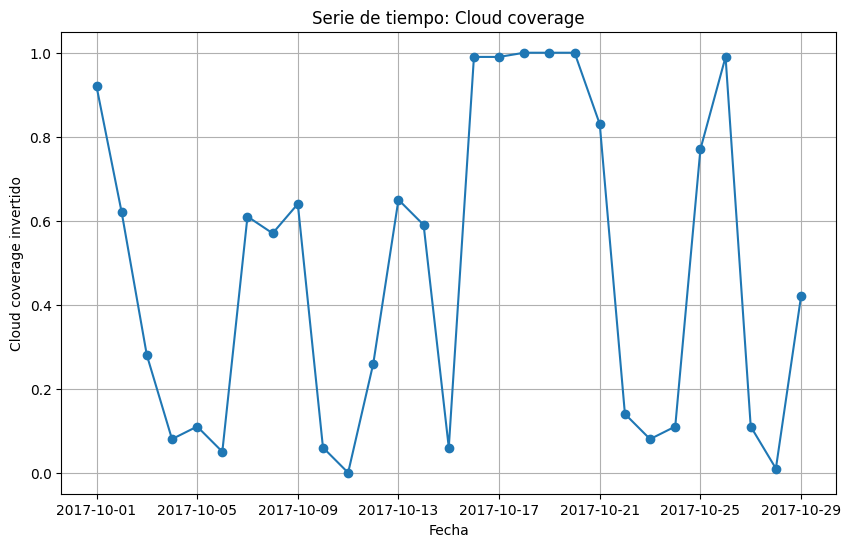

In [43]:
#graficando solo el ultimo mes de datos 
semana1_df = df.iloc[608:,]

plt.figure(figsize=(10, 6))
plt.plot(semana1_df['Fecha'], semana1_df['Valores'], marker='o', linestyle='-', color='orange')
plt.title('Serie de tiempo: Solar energy')
plt.xlabel('Fecha')
plt.ylabel('Solar energy')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))  
plt.plot(semana1_df['Fecha'], semana1_df['Cloud'], marker='o', linestyle='-')
plt.title('Serie de tiempo: Cloud coverage')
plt.xlabel('Fecha')
plt.ylabel('Cloud coverage invertido')
plt.grid(True)
plt.show()


In [44]:
# Para ingresar los datos a al modelo es necesario que esten normalizados pues facilita el ajuste 

#en este caso cloud coverage ya se encuentra en un rango de valores entre 0 y 1

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Valores', 'Cloud']] = scaler.fit_transform(df[['Valores', 'Cloud']])
print(df)

         Fecha   Valores  Cloud
0   2016-02-01  0.496054   0.90
1   2016-02-02  0.029774   0.20
2   2016-02-03  0.055338   0.13
3   2016-02-04  0.708811   0.63
4   2016-02-05  0.225312   0.48
..         ...       ...    ...
632 2017-10-25  0.331703   0.77
633 2017-10-26  0.677802   0.99
634 2017-10-27  0.383638   0.11
635 2017-10-28  0.146729   0.01
636 2017-10-29  0.200605   0.42

[637 rows x 3 columns]


In [181]:
#Una vez normalizados, se necesita que sean datos supervisados 
data = df
#definir el tamaño del paso (look-back), por ejemplo, 20
#elegimos 20 para probar, pues en la correlacion con desfase habia un maximo con 19 valores desplazados.
look_back = 10
X, y = [], [] #para las secuencias temporales de entrada (X) y salida (y)

for i in range(len(data) - look_back):
    #crea una secuencia temporal de cloud
    seq_cloud = data['Cloud'][i:i+look_back].tolist()
    
    #obtiene el valor de energia solar en el siguiente paso de tiempo
    target = data['Valores'][i+look_back]
    
    # Agrega la secuencia temporal a X y el valor de salida a y
    X.append(seq_cloud)
    y.append(target)

# Convierte las listas X y y en DataFrames si es necesario
X = pd.DataFrame(X, columns=[f'Cloud(t-{i})' for i in range(look_back, 0, -1)])
y = pd.Series(y, name='Valores(t+1)')

# X contendrá las secuencias temporales de temperatura y y contendrá los valores de energía solar en el siguiente paso de tiempo
print(X)
print(y)

     Cloud(t-10)  Cloud(t-9)  Cloud(t-8)  Cloud(t-7)  Cloud(t-6)  Cloud(t-5)  \
0           0.90        0.20        0.13        0.63        0.48        0.87   
1           0.20        0.13        0.63        0.48        0.87        0.79   
2           0.13        0.63        0.48        0.87        0.79        0.13   
3           0.63        0.48        0.87        0.79        0.13        0.00   
4           0.48        0.87        0.79        0.13        0.00        0.75   
..           ...         ...         ...         ...         ...         ...   
622         0.06        0.99        0.99        1.00        1.00        1.00   
623         0.99        0.99        1.00        1.00        1.00        0.83   
624         0.99        1.00        1.00        1.00        0.83        0.14   
625         1.00        1.00        1.00        0.83        0.14        0.08   
626         1.00        1.00        0.83        0.14        0.08        0.11   

     Cloud(t-4)  Cloud(t-3)  Cloud(t-2)

Ahora realizamos la red neuronal recurrente que sirve principalmente para pronostico de valores a partir de series de tiempo. Los parametros usados tambien son de forma aleatoria. 

In [182]:
from sklearn.model_selection import train_test_split
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Definir la arquitectura de la red neuronal

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_29 (SimpleRNN)   (None, 64)                4224      
                                                                 
 dense_103 (Dense)           (None, 64)                4160      
                                                                 
 dropout_57 (Dropout)        (None, 64)                0         
                                                                 
 dense_104 (Dense)           (None, 1)                 65        
                                                                 
Total params: 8449 (33.00 KB)
Trainable params: 8449 (33.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
9/9 - 1s - loss: 0.1441 - val_loss: 0.0810 - 1s/epoch - 156ms/step
Epoch 2/500
9/9 - 0s - loss: 0.1007 - val_loss: 0.0724 - 48ms/epoch - 5m

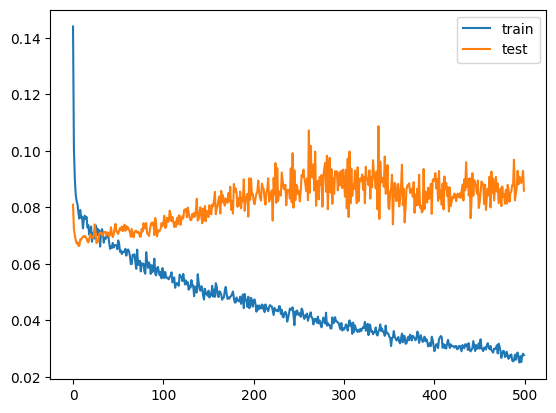

In [193]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import pyplot


model = Sequential() 
# Agregar una capa RNN con 64 nodos
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], 1)))
#model.add(LSTM(64, input_shape=(X_train.shape[1],1)))
model.add(Dense(64, activation='relu')) #capa oculta  #relu para que salga con valores de 0 a 1
model.add(Dropout(0.4))
# Agregar una capa densa para la salida
model.add(Dense(1)) 

# Compilar el modelo con una función de pérdida y un optimizador
model.compile(loss='mean_squared_error', optimizer='adam') #: Calcula el error cuadratico medio.

# Imprimir un resumen del modelo
model.summary()

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular el error cuadrático medio entre el valor de salida y el esperado
mse = mean_squared_error(y_test, y_pred)
print(f"Error Cuadrático Medio en el conjunto de prueba: {mse:.2f}")
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

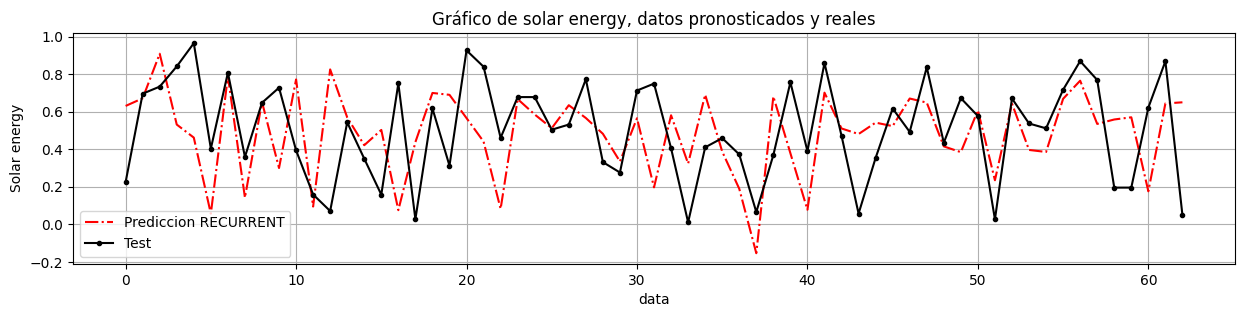

In [194]:
#grafico de linea 
serie= y_test
serie_reset = serie.reset_index(drop=True)
plt.figure(figsize=(15, 3))  # Tamaño del gráfico
plt.plot(y_pred, linestyle='-.', color='r',label='Prediccion RECURRENT')
plt.plot(serie_reset, marker='.', linestyle='-', color='k', label='Test')
plt.title('Gráfico de solar energy, datos pronosticados y reales')
plt.xlabel('data')
plt.ylabel('Solar energy')
plt.legend()
plt.grid(True)
plt.show()

En este caso, el modelo en algunos rangos se ajusta bastante.

Epoch 1/500
9/9 - 3s - loss: 0.4556 - val_loss: 0.2814 - 3s/epoch - 310ms/step
Epoch 2/500
9/9 - 0s - loss: 0.3126 - val_loss: 0.2236 - 75ms/epoch - 8ms/step
Epoch 3/500
9/9 - 0s - loss: 0.3025 - val_loss: 0.2464 - 79ms/epoch - 9ms/step
Epoch 4/500
9/9 - 0s - loss: 0.3002 - val_loss: 0.2493 - 79ms/epoch - 9ms/step
Epoch 5/500
9/9 - 0s - loss: 0.2865 - val_loss: 0.2235 - 73ms/epoch - 8ms/step
Epoch 6/500
9/9 - 0s - loss: 0.2859 - val_loss: 0.2309 - 81ms/epoch - 9ms/step
Epoch 7/500
9/9 - 0s - loss: 0.2797 - val_loss: 0.2328 - 77ms/epoch - 9ms/step
Epoch 8/500
9/9 - 0s - loss: 0.2836 - val_loss: 0.2467 - 76ms/epoch - 8ms/step
Epoch 9/500
9/9 - 0s - loss: 0.2781 - val_loss: 0.2249 - 78ms/epoch - 9ms/step
Epoch 10/500
9/9 - 0s - loss: 0.2677 - val_loss: 0.2249 - 75ms/epoch - 8ms/step
Epoch 11/500
9/9 - 0s - loss: 0.2674 - val_loss: 0.2257 - 81ms/epoch - 9ms/step
Epoch 12/500
9/9 - 0s - loss: 0.2842 - val_loss: 0.2248 - 73ms/epoch - 8ms/step
Epoch 13/500
9/9 - 0s - loss: 0.2731 - val_loss: 

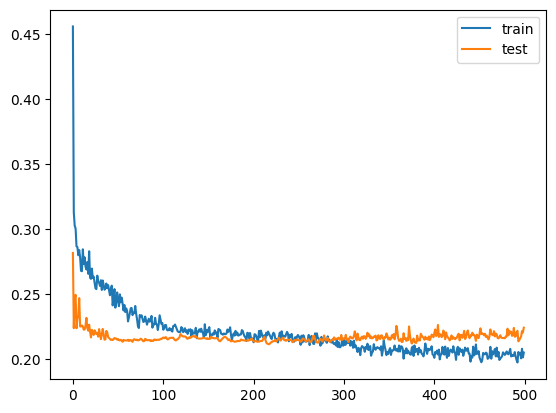

In [231]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1],1)))
model.add(Dense(64, activation='relu')) #capa oculta  #relu para que salga con valores de 0 a 1
model.add(Dropout(0.8))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_test, y_test), verbose=2, shuffle=False)
# plot history
y_pred2= model.predict(X_test)
mse = mean_squared_error(y_test, y_pred2)
print(f"Error Cuadrático Medio en el conjunto de prueba: {mse:.2f}")
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

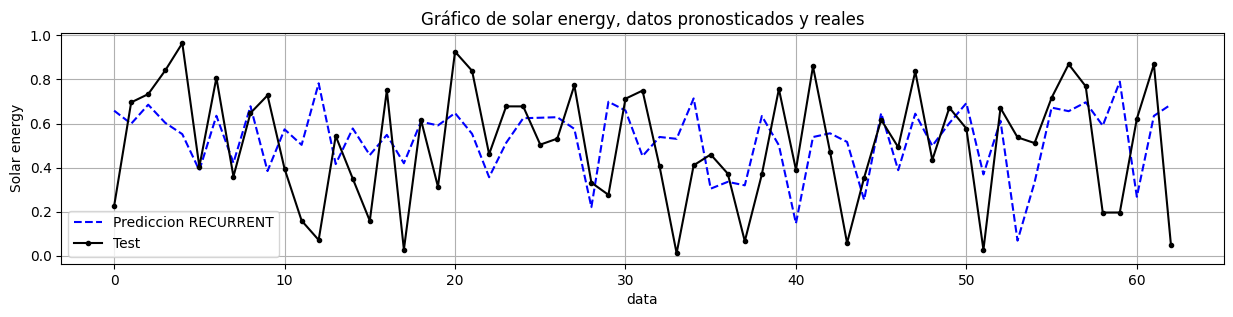

In [241]:
plt.figure(figsize=(15, 3))  # Tamaño del gráfico
plt.plot(y_pred2, linestyle='--', color='b',label='Prediccion RECURRENT')
plt.plot(serie_reset, marker='.', linestyle='-', color='k', label='Test')
plt.title('Gráfico de solar energy, datos pronosticados y reales')
plt.xlabel('data')
plt.ylabel('Solar energy')
plt.legend()
plt.grid(True)
plt.show()

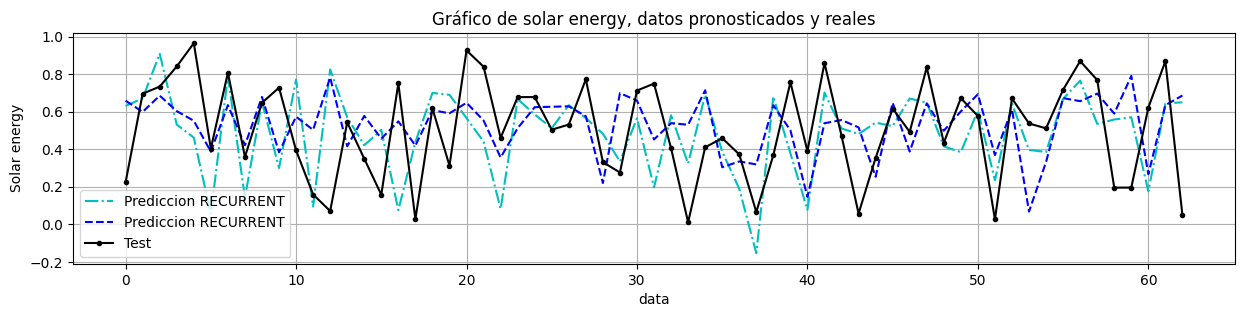

In [235]:
#grafico de linea 
serie= y_test
serie_reset = serie.reset_index(drop=True)
plt.figure(figsize=(15, 3))  # Tamaño del gráfico
plt.plot(y_pred, linestyle='-.', color='c',label='Prediccion RECURRENT')
plt.plot(y_pred2, linestyle='--', color='b',label='Prediccion RECURRENT')
plt.plot(serie_reset, marker='.', linestyle='-', color='k', label='Test')
plt.title('Gráfico de solar energy, datos pronosticados y reales')
plt.xlabel('data')
plt.ylabel('Solar energy')
plt.legend()
plt.grid(True)
plt.show()